A few key concepts that we will revisit in this walk-through are:

1. Apply String Indexer method to find the index of the categorical columns

2. Apply OneHot encoding for the categorical columns

3. Apply String indexer for the output variable “label” column

4. VectorAssembler is applied for both categorical columns and numeric columns. VectorAssembler is a transformer that combines a given list of columns into a single vector column.

**Step 1**: Install Spark

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# install findspark using pip
!pip install -q findspark

In [ ]:
!pip3 install pyspark==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 204.8 MB 51 kB/s 
     |████████████████████████████████| 198 kB 21.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186690 sha256=d9fdf0f147cf5005ce28470cfad7dcafa04fba023cab86b25da659b923aa8ab1
  Stored in directory: /root/.cache/pip/wheels/9a/39/f6/970565f38054a830e9a8593f388b36e14d75dba6c6fdafc1ec
Successfully built pyspark


In [ ]:
import findspark
findspark.init()

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark


In [ ]:
# Create spark_session
spark_session = SparkSession.builder.getOrCreate()

In [ ]:
sc = spark_session.sparkContext

**Step 2**: Insert SQLContext wrapper around the Spark Context

In [ ]:
from pyspark.sql import SQLContext
url = "https://raw.githubusercontent.com/guru99-edu/R-Programming/master/adult_data.csv"
from pyspark import SparkFiles
sc.addFile(url)
sqlContext = SQLContext(sc)

**Step 3**: Read the contents from the 'adults.csv' file

In [ ]:
df = sqlContext.read.csv(SparkFiles.get("adult_data.csv"), header=True, inferSchema= True)

**Step 4**: Examine the schema of the underlying dataset

In [ ]:
df.printSchema()

root
 |-- x: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [ ]:
df.show()

+---+---+----------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|  x|age|       workclass|fnlwgt|   education|educational-num|    marital-status|       occupation| relationship|              race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---+----------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|  1| 25|         Private|226802|        11th|              7|     Never-married|Machine-op-inspct|    Own-child|             Black|  Male|           0|           0|            40| United-States| <=50K|
|  2| 38|         Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|      Husband|             White|  Male|           0|           0|            50| United-

**Step 5**: Function that converts the data types of the DataFrame columns

In [ ]:
# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df 

In [ ]:
# Assign all column names to `columns`
columns = ['age', 'fnlwgt','capital-gain', 'educational-num', 'capital-loss', 'hours-per-week']

**Step 6**: Convert the data types of the above mentioned columns into a float type

In [ ]:
from pyspark.sql.types import *
# Conver the `df` columns to `FloatType()`
df = convertColumn(df, columns, FloatType())

**Step 7**: Confirm that the data type has been converted into float

In [ ]:
df.dtypes

[('x', 'int'),
 ('age', 'float'),
 ('workclass', 'string'),
 ('fnlwgt', 'float'),
 ('education', 'string'),
 ('educational-num', 'float'),
 ('marital-status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('gender', 'string'),
 ('capital-gain', 'float'),
 ('capital-loss', 'float'),
 ('hours-per-week', 'float'),
 ('native-country', 'string'),
 ('income', 'string')]

**Step 8**: Drop rows that have a '?' in them



In [ ]:
import numpy as np 
df = df.replace("?", "np.Nan")

# Remove missing value
df = df.filter("workclass != 'np.Nan'").filter("occupation != 'np.Nan'").filter("`native-country` != 'np.Nan'")
df.show()

+---+----+----------------+--------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|  x| age|       workclass|  fnlwgt|   education|educational-num|    marital-status|       occupation| relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+----+----------------+--------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|  1|25.0|         Private|226802.0|        11th|            7.0|     Never-married|Machine-op-inspct|    Own-child|Black|  Male|         0.0|         0.0|          40.0| United-States| <=50K|
|  2|38.0|         Private| 89814.0|     HS-grad|            9.0|Married-civ-spouse|  Farming-fishing|      Husband|White|  Male|         0.0|         0.0|          50.0| United-States| <=50K|
|  3|28.0|       Local-gov|336951.0

**Step 9:** Use "StringIndexer" and "OneHotEncoding" to convert categorical features into numeric values

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

#Store all the categorical columns
categorical_Cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
pipeline_stages = []

#Iterate throughthe categorical columns
for categoricalCol in categorical_Cols :
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_conv"])
    pipeline_stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
#Add another stage to the ML pipeline
pipeline_stages += [label_stringIdx]

#Store all the numeric columns
numericCols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
assembler_Inputs = [c + "_conv" for c in categorical_Cols] + numericCols
assembler = VectorAssembler(inputCols=assembler_Inputs, outputCol="features")
pipeline_stages += [assembler]

**Step 10**: We use the ML Pipeline to chain multiple Transformers and Estimators together to screate the machine learning workflow.

In [ ]:
from pyspark.ml import Pipeline

ml_pipe = Pipeline(stages = pipeline_stages)
# Fit and transform the data
pipe_data = ml_pipe.fit(df).transform(df)
selectedCols = ['label', 'features'] + df.columns
df = pipe_data.select(selectedCols)
df.show()

+-----+--------------------+---+----+----------------+--------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|label|            features|  x| age|       workclass|  fnlwgt|   education|educational-num|    marital-status|       occupation| relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+-----+--------------------+---+----+----------------+--------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|  0.0|(95,[0,11,22,33,4...|  1|25.0|         Private|226802.0|        11th|            7.0|     Never-married|Machine-op-inspct|    Own-child|Black|  Male|         0.0|         0.0|          40.0| United-States| <=50K|
|  0.0|(95,[0,6,21,36,40...|  2|38.0|         Private| 89814.0|     HS-grad|            9.0|Married-civ-spouse|  Farming

**Step 11:** Split the data set into Train and Test data sets respectively

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 12345)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 31545
Test Dataset Count: 13677


**Step 12**: Create a Logistic Regression Model

In [ ]:
# Import `LogisticRegression`
from pyspark.ml.classification import LogisticRegression

# Initialize `lr`
lr = LogisticRegression(labelCol="label",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the data to the model
linearModel = lr.fit(train)

**Step 13**: Make predictions on test data using the transform() method.


In [ ]:
predictions = linearModel.transform(test)

**Step 14**: Examine the elements in predictions object

In [ ]:
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- x: integer (nullable = true)
 |-- age: float (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: float (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: float (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: float (nullable = true)
 |-- capital-loss: float (nullable = true)
 |-- hours-per-week: float (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



**Step 15**: Investigate the predictions

In [ ]:
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(50)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.79876961965233...|       0.0|[0.68971122934134...|
|  0.0|[0.78132835086031...|       0.0|[0.68596633332400...|
|  0.0|[0.53451133331672...|       0.0|[0.63053469278484...|
|  0.0|[0.69231624365181...|       0.0|[0.66648198845505...|
|  0.0|[0.72132307261904...|       0.0|[0.67289830011546...|
|  0.0|[0.63428066917326...|       0.0|[0.65345945627976...|
|  0.0|[0.57080622929525...|       0.0|[0.63894918753099...|
|  0.0|[0.39482989245959...|       0.0|[0.59744485487626...|
|  0.0|[0.22808136455443...|       0.0|[0.55677443185898...|
|  0.0|[0.93474652562327...|       0.0|[0.71803725965986...|
|  0.0|[0.97446125361469...|       0.0|[0.72600782663058...|
|  0.0|[0.89798700544308...|       0.0|[0.71053565602872...|
|  0.0|[0.91481637049542...|       0.0|[0.71398472917133...|
|  0.0|[0.90222304752348

**Step 16**: Evaluate the predictions

**Evaluating the Model** - Since the Logistic model at hand is a binary classification model (given that the outcome is 1 or 0), the BinaryClassificationEvaluator from the ***pyspark.ml.evaluation*** module will be utilized to evaluate the Logistic Regression Model.

The BinaryClassificationEvaluator calculates the area under the ROC which is is one of the most important evaluation metrics for checking any classification model’s performance. It finds the best model by maximizing the model evaluation metric that is the area under the specified curve. The closer the area Under Curve is to one (1), the better the model is!

For more details, check out: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName="areaUnderROC")

# Evaluate the predictions
print("The area under ROC for test data set is {}".format(evaluator.evaluate(predictions)))

The area under ROC for test data set is 0.8843278752871817


In [ ]:
#Add Majed
!pip install handyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


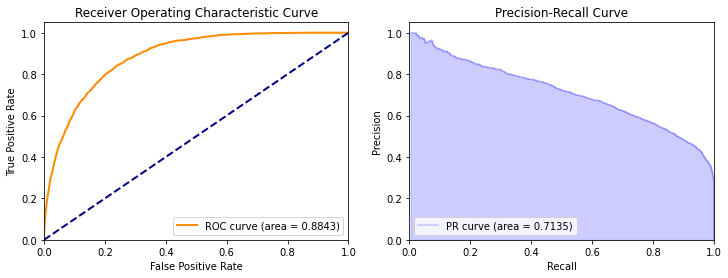

In [ ]:
import handyspark
bcm = handyspark.BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])